# `SimPEG(emg3d)`

For the "original" versions, see:
- https://curvenote.com/@prisae/emg3d-as-solver-for-simpeg/first-try [the very original]
- https://curvenote.com/@prisae/emg3d-as-solver-for-simpeg/simpeg-emg3d-inversion-automatic-grid [original with automatic gridding]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import emg3d
import simpeg

%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget

## Create a model and survey

In [3]:
rec_x = (np.arange(20)-10)*200+100
rec = emg3d.surveys.txrx_coordinates_to_dict(emg3d.RxElectricPoint, (rec_x, 0, -800, 0, 0))

src_x = np.array([-1900, -1500, -1100, -700, 700, 1100, 1500, 1900])
src = emg3d.surveys.txrx_coordinates_to_dict(emg3d.TxElectricDipole, (src_x, -100, -900, 0, 0))

survey = emg3d.surveys.Survey(
    sources=src,
    receivers=rec,
    frequencies=2.0,
    noise_floor=1e-14,
    relative_error=0.01,
)
survey

:: Survey ::

<xarray.Dataset> Size: 3kB
Dimensions:   (src: 8, rec: 20, freq: 1)
Coordinates:
  * src       (src) <U6 192B 'TxED-1' 'TxED-2' 'TxED-3' ... 'TxED-7' 'TxED-8'
  * rec       (rec) <U7 560B 'RxEP-01' 'RxEP-02' ... 'RxEP-19' 'RxEP-20'
  * freq      (freq) <U3 12B 'f-1'
Data variables:
    observed  (src, rec, freq) complex128 3kB (nan+nanj) ... (nan+nanj)
Attributes:
    noise_floor:     1e-14
    relative_error:  0.01

In [4]:
grid = emg3d.TensorMesh([np.ones(22)*200, np.ones(20)*200, np.ones(16)*200], x0=(-2200, -2000, -3000))
grid

TensorMesh: 7,040 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     22     -2,200.00      2,200.00    200.00    200.00    1.00
   y     20     -2,000.00      2,000.00    200.00    200.00    1.00
   z     16     -3,000.00        200.00    200.00    200.00    1.00

In [5]:
sigma = np.ones(grid.shape_cells)
sigma[:, :, -1] = 1/1e8        # air
sigma[:, :, -6:-1] = 1/0.33    # sea-water
model_start = emg3d.Model(grid, sigma.copy(), mapping='Conductivity')
sigma[6:-6, 1:-1, 6] = 1/100  # target
model_true = emg3d.Model(grid, sigma.copy(), mapping='Conductivity')
sigma = sigma.ravel('F')
model_start

Model: conductivity; isotropic; 22 x 20 x 16 (7,040)

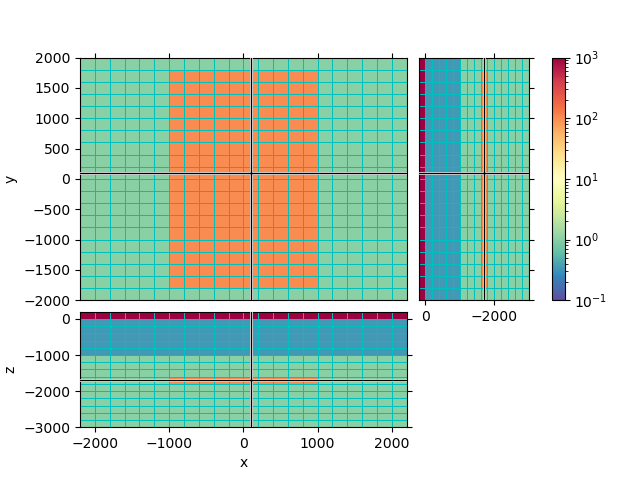

In [6]:
grid.plot_3d_slicer(
    1/model_true.property_x, zslice=-1600,
    pcolor_opts={
        'cmap': 'Spectral_r',
        'norm': LogNorm(vmin=.1, vmax=1000), 'lw': 0.5, 'color': 'c',
    },
)
fig = plt.gcf()
fig.axes[0].set_title('Resistivity Model')
fig.axes[0].plot(rec_x, rec_x*0, 'bo')
fig.axes[0].plot(src_x, src_x*0, 'w*')

## Create a Simulation

In [7]:
inds_active = np.zeros(model_true.shape, dtype=bool)
#inds_active[1:-1, 1:-1, 1:-7] = True
inds_active[:, :, :-6] = True
inds_active = inds_active.ravel('F')
active_map = simpeg.maps.InjectActiveCells(grid, inds_active, sigma[~inds_active])
nP = int(inds_active.sum())
conductivity_map = active_map * simpeg.maps.ExpMap(nP=nP)

In [8]:
# Create an emg3d Simulation instance
sim = emg3d.simulations.Simulation(
    survey=survey.copy(),
    model=model_true,
    gridding='both',
    max_workers=9,
    gridding_opts={'vector': 'xyz'},
    solver_opts={'tol_gradient': 1e-2},
    receiver_interpolation='linear',
    tqdm_opts=False,
)
sim

:: Simulation ::

- Survey: 8 sources; 20 receivers; 1 frequencies
- Model: conductivity; isotropic; 22 x 20 x 16 (7,040)
- Gridding: Frequency- and source-dependent grids; 48 x 48 x 32 (73,728)

In [9]:
# Compute observed data with added noise
sim.compute(observed=True, min_offset=300)
sim.clean('computed')

# Change model to start model
sim.model = model_start

# Compute synthetic initial data
sim.compute()
sim.survey.data['start'] = sim.survey.data.synthetic
sim.clean('computed')

In [10]:
kernel = emg3d.inversion.simpeg.Kernel(
    sim,
    sigmaMap=conductivity_map,
    verbose=False,
)

## Run inversion

### TODO: Add much of this to `emg3d.inversion.simpeg`

In [11]:
em_data = simpeg.data.Data(
    kernel.survey,
    dobs=kernel.data2simpeg(sim.data.observed.data),
    standard_deviation=kernel.data2simpeg(sim.survey.standard_deviation.data),
)

m0 = model_start.property_x.ravel('F')[inds_active] * np.log(1.)

dmis = simpeg.data_misfit.L2DataMisfit(data=em_data, simulation=kernel)

In [12]:
%%time
# TODO: Add timing to inversion.simpeg

# Define the regularization (model objective function)
reg = simpeg.regularization.WeightedLeastSquares(
    sim.model.grid,
    active_cells=inds_active,
    reference_model=m0,
    alpha_s=1e-8,
    alpha_x=1,
    alpha_y=10,
    alpha_z=1
)

opt = simpeg.optimization.InexactGaussNewton(
    maxIter=2, maxIterLS=20, maxIterCG=20, tolCG=1e-3,
)
inv_prob = simpeg.inverse_problem.BaseInvProblem(dmis, reg, opt)
starting_beta = simpeg.directives.BetaEstimate_ByEig(beta0_ratio=1)
save = simpeg.directives.SaveOutputDictEveryIteration()

beta_schedule = simpeg.directives.BetaSchedule(coolingFactor=2, coolingRate=1)
target_misfit = simpeg.directives.TargetMisfit(chifact=1)

directives_list = [
    starting_beta,
    beta_schedule,
    target_misfit,
    save
]
em_inversion = simpeg.inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_conductivity_model = em_inversion.run(m0)


Running inversion with SimPEG v0.14.3.dev3200+g2aca527a8

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Kernel problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.23e-01  2.38e+04  0.00e+00  2.38e+04    1.07e+04      0              
   1  3.61e-01  1.05e+04  2.03e+03  1.13e+04    3.66e+03      0              
   2  1.81e-01  6.77e+03  6.68e+03  7.98e+03    1.36e+03      0              
------------------------- STOP! -------------------------
0 : |fc-fOld| = 3.2927e+03 <= tolF*(1+|f0|) = 2.3806e+03
0 : |xc-x_last| = 7.2501e+00 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 1.3619e+03 <= tolG       

In [13]:
# TODO: Add this to inversion.simpeg
sim.survey.data["it0"] = sim.survey.data.start
for k, v in save.outDict.items():
    sim.survey.data[f"it{v['iter']}"] = sim.survey.data.observed.copy(data=kernel.data2emg3d(save.outDict[k]['dpred']))

## Plots

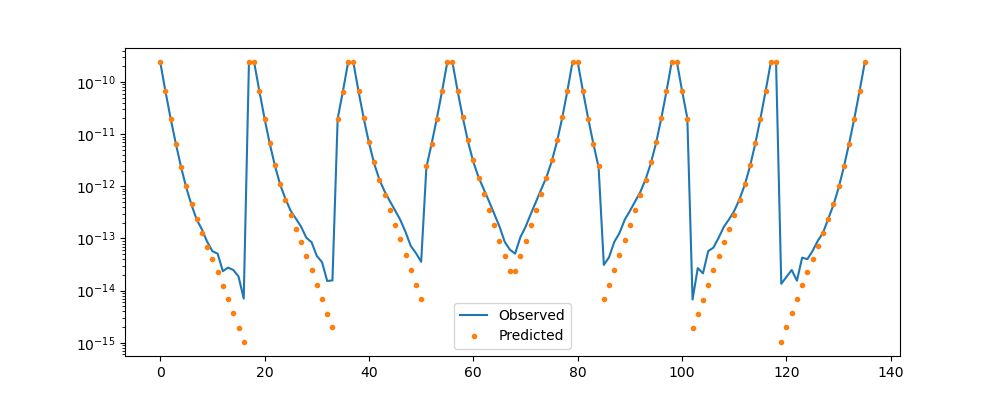

In [14]:
plt.figure(figsize=(10, 4))
iteration = len(save.outDict.keys())
plt.semilogy(abs(em_data.dobs), '-', label='Observed')
plt.semilogy(abs(save.outDict[iteration]['dpred']), '.', label='Predicted')
plt.legend()

In [15]:
import toyexample

Depth slice: -1700.0 m


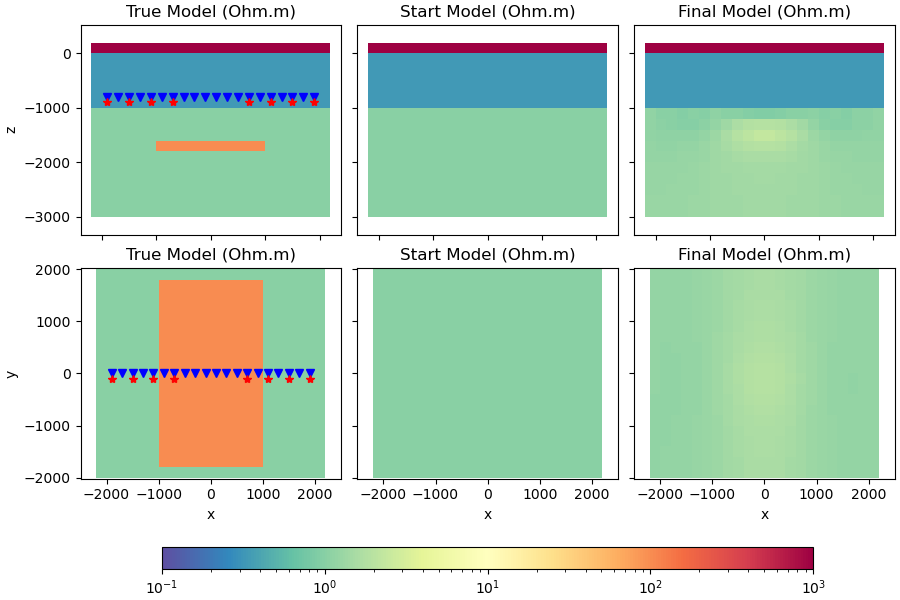

In [16]:
toyexample.plot_models(sim, model_start, model_true, 6)

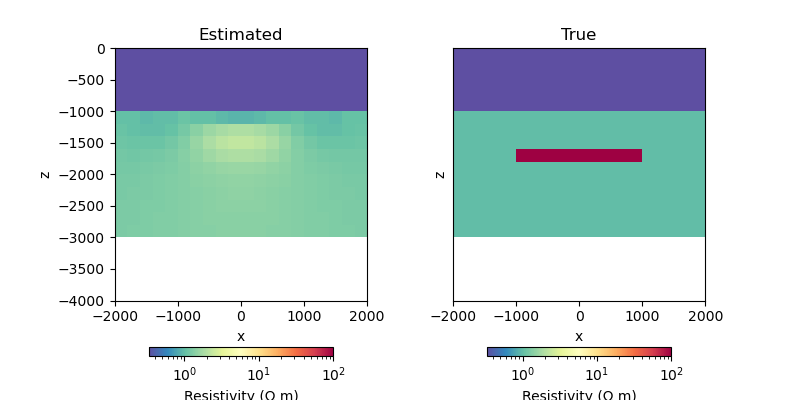

In [17]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))

sigm_est = conductivity_map * save.outDict[iteration]['m']
sigmas = [sigm_est, sigma]
titles = ["Estimated", "True"]
for ii, ax in enumerate(axs):
    out = grid.plot_slice(
        1./sigmas[ii], grid=False, normal='Y', 
        pcolor_opts={'cmap':'Spectral_r', 'norm':LogNorm(vmin=0.33, vmax=100)}, 
        ax=ax,
    )
    ax.set_aspect(1)
    ax.set_ylim(-4000, 0)
    ax.set_xlim(-2000, 2000)
    if ii == 1:
        ax.set_yticks([])
    ax.set_title(titles[ii])
    cb = plt.colorbar(out[0], ax=ax, fraction=0.03, orientation='horizontal')
    cb.set_label("Resistivity (Ω m)")

In [18]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Fri Aug 30 15:18:56 2024 CEST

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.12.5 | packaged by conda-forge | (main, Aug  8 2024, 18:36:51) [GCC
  12.4.0]

             numpy : 1.26.4
             scipy : 1.14.0
             numba : 0.60.0
             emg3d : 1.8.4.dev10+g825638d.d20240830
           empymod : 2.3.1
            xarray : 2024.7.0
        discretize : 0.10.0
              h5py : 3.11.0
        matplotlib : 3.9.1
              tqdm : 4.66.5
           IPython : 8.26.0
            simpeg : 0.14.3.dev3200+g2aca527a8
            pydiso : 0.0.5
--------------------------------------------------------------------------------